In [1]:
#############################################################################################

In [66]:
import os 
import nltk 
import re
import string
import numpy as np
import pandas as pd
import rtfConverter as rtf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn import cross_validation,linear_model
from collections import Counter
import warnings # Stop deprecation warnings from being printed
warnings.filterwarnings("ignore", category=DeprecationWarning)
from nltk.corpus import stopwords 
os.chdir('E:/VINOD KUMAR/OMEGA_PROJECT_NLP')
from sklearn.svm import LinearSVC
# spacy
import spacy
import en_core_web_sm 
nlp2= en_core_web_sm.load()

In [3]:
#############################################################################################

In [4]:
os.getcwd()

'E:\\VINOD KUMAR\\OMEGA_PROJECT_NLP'

In [5]:
os.listdir('E:\\VINOD KUMAR\\OMEGA_PROJECT_NLP')

['COMPLETE_FLOW_PROJECT_REPORT.xlsx',
 'Guliford June 1-25, 2018.xlsx',
 'IPM June1-17, 2018.xlsx',
 'rtfConverter.py',
 'Test Data',
 'Train Data',
 'Train_data_Guliford Jan,2017 -May,2018.xlsx',
 'Train_data_IPM Jan,2017-May,2018.xlsx',
 '__pycache__']

In [6]:
os.listdir('E:/VINOD KUMAR/OMEGA_PROJECT_NLP/Train Data')

['Train_data_Guliford Jan,2017 -May,2018.xlsx',
 'Train_data_IPM Jan,2017-May,2018.xlsx']

In [7]:
# read the files if exists in working directory
if (os.path.exists("Train_data_Guliford Jan,2017 -May,2018.xlsx"))==True & (os.path.exists('Guliford June 1-25, 2018.xlsx'))==True:
    print("Train,Test data exists reading as dataframe")
    #print("Files in directory are:",os.listdir(cwd))
    #reading training data into a dataframe using pandas
    actual_data=pd.read_excel("Train_data_Guliford Jan,2017 -May,2018.xlsx")
    test_data=pd.read_excel('Guliford June 1-25, 2018.xlsx')
    print(actual_data.shape,test_data.shape)
else: 
    print("file not exists")
    print("Files in directory are:",os.listdir(cwd))

Train,Test data exists reading as dataframe
(93289, 8) (2606, 16)


In [8]:
##########################################################################################

In [9]:
print(actual_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93289 entries, 0 to 93288
Data columns (total 8 columns):
FileID                  93289 non-null int64
clientid                93289 non-null int64
PID                     89552 non-null float64
SUMMARY                 90253 non-null object
DATA                    93289 non-null object
Categories1             93289 non-null object
Sub_categories1         93289 non-null object
Previous_Appointment    93289 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2606 entries, 0 to 2605
Data columns (total 16 columns):
FileID                  2606 non-null int64
clientid                2606 non-null int64
PID                     2606 non-null int64
SUMMARY                 2510 non-null object
DATA                    2606 non-null object
Categories1             2606 non-null object
Sub_categories1         2606 non-null object
Categories2             0 non-null floa

In [10]:
#################################################################################################

In [11]:
s=actual_data.Categories1.value_counts()
ax=s.plot.bar(figsize=(10,5))
for i, v in s.reset_index().iterrows():
    ax.text(i, v.Categories1, v.Categories1, color='red')    

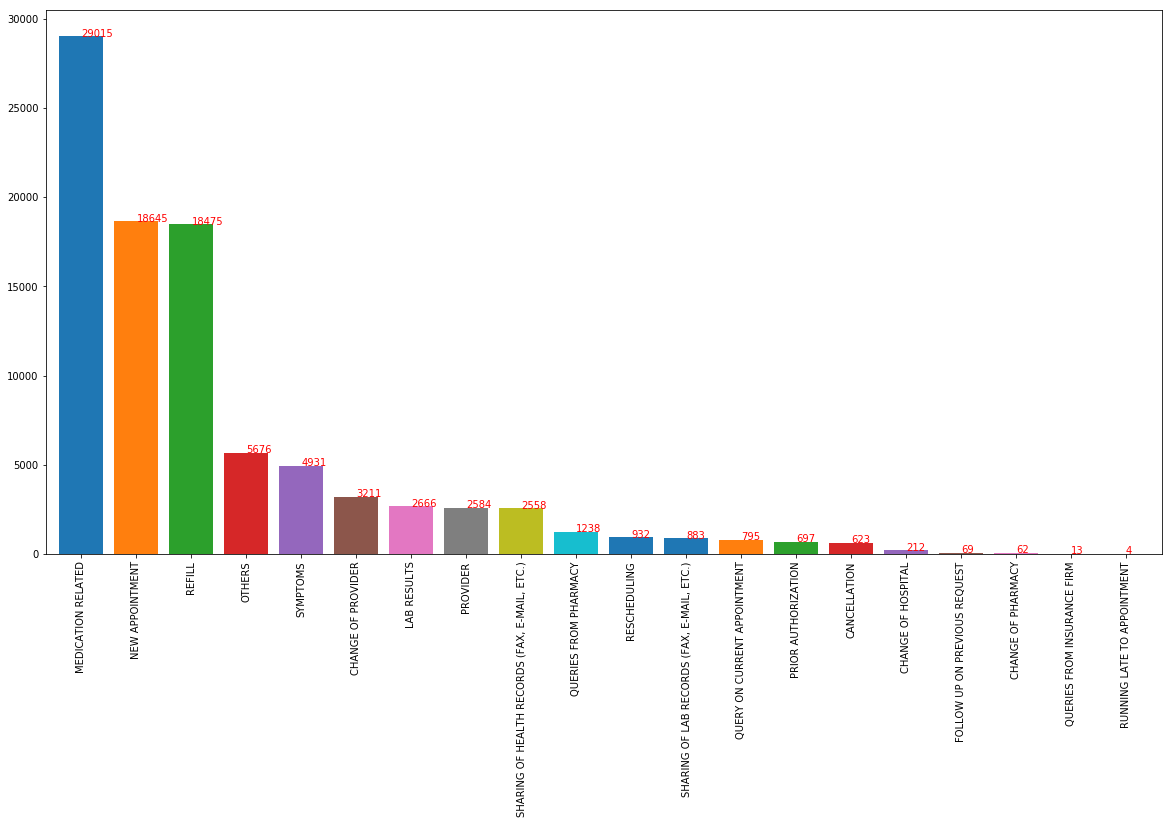

In [12]:
#ax = actual_data.groupby("Sub_categories1").size().plot(kind="bar",figsize=(20,10))
#print(actual_data.Sub_categories1.value_counts(),ax)
s=actual_data.Sub_categories1.value_counts()
ax=s.plot.bar(width=.8,figsize=(20,10))
for i, v in s.reset_index().iterrows():
    ax.text(i, v.Sub_categories1, v.Sub_categories1, color='red')

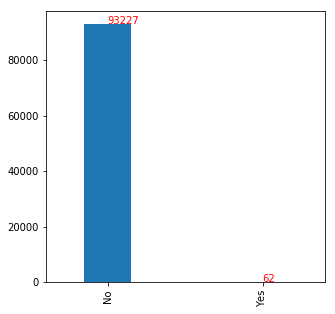

In [18]:
s=actual_data.Previous_Appointment.value_counts()
ax=s.plot.bar(width=.3,figsize=(5,5))
for i, v in s.reset_index().iterrows():
    ax.text(i, v.Previous_Appointment, v.Previous_Appointment, color='red')

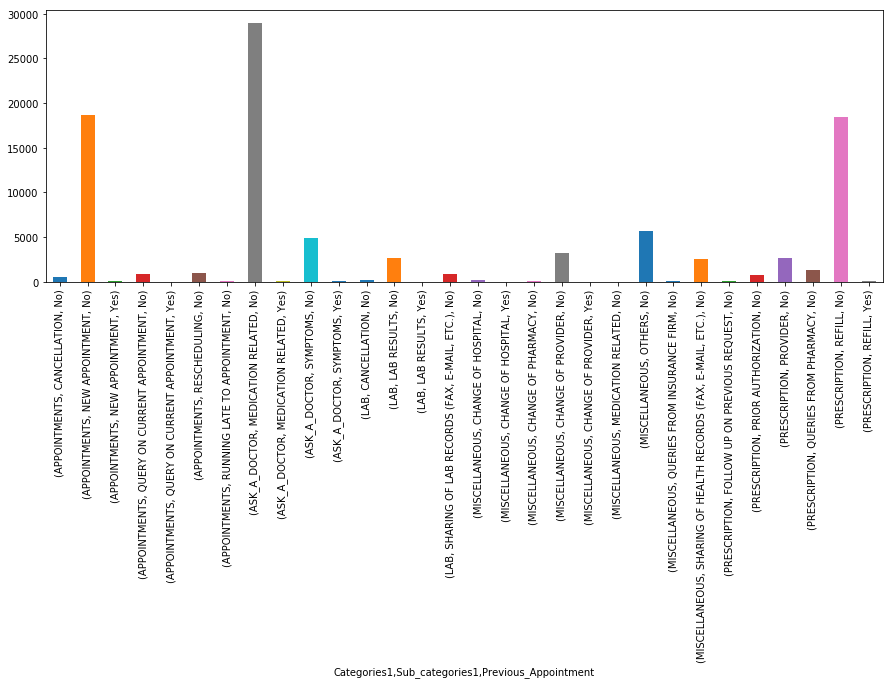

In [19]:
actual_data_ax = actual_data.groupby(["Categories1","Sub_categories1","Previous_Appointment"]).size().plot(kind="bar", figsize=(15, 5))

In [20]:
#Each word frequency count in Whole Corpus
freq_count_data = pd.Series(' '.join(actual_data['DATA'].astype(str)).split()).value_counts()
print(len(freq_count_data),freq_count_data.sum())

238572 14000777


(count    238572.000000
 mean         58.685751
 std        1947.211867
 min           1.000000
 25%           1.000000
 50%           1.000000
 75%           3.000000
 max      444163.000000
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x2590db25828>)

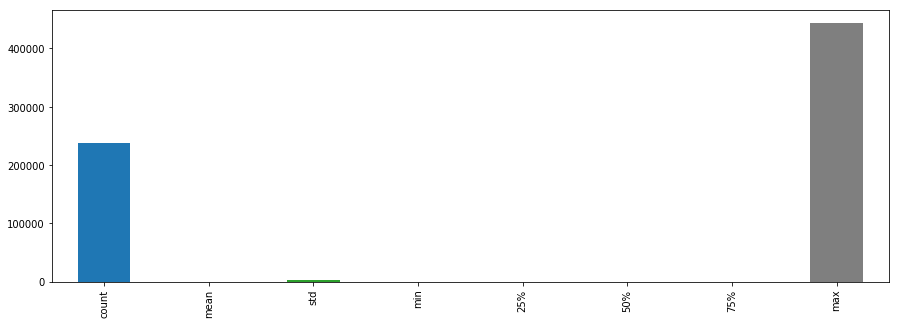

In [21]:
freq_count_data.describe(),freq_count_data.describe().plot(kind="bar",figsize=(15, 5))

(count    238572.000000
 mean         58.685751
 std        1947.211867
 min           1.000000
 25%           1.000000
 50%           1.000000
 75%           3.000000
 max      444163.000000
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x2590db17f28>)

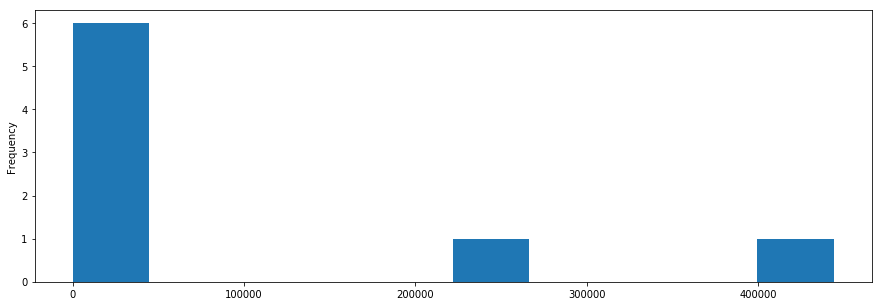

In [22]:
freq_count_data.describe(),freq_count_data.describe().plot(kind="hist",figsize=(15, 5))

In [ ]:
#############################################################################################################

In [23]:
actual_data["DATA"]=actual_data["DATA"].astype("str")
actual_data["SUMMARY"]=actual_data["SUMMARY"].astype("str")
test_data["DATA"]=test_data["DATA"].astype("str")
test_data["SUMMARY"]=test_data["SUMMARY"].astype("str")

In [24]:
#Combining SUMMARY column with Spacy_sentences
actual_data['combined_sent'] = actual_data['SUMMARY'].map(str) +" " +actual_data['DATA']
test_data['combined_sent'] = test_data['SUMMARY'].map(str) +" " +test_data['DATA']

In [126]:
def process_text(input_string):
    input_string = rtf.striprtf(input_string)
    string = re.sub(r"Phone Note", " ", input_string)
    string = re.sub(r"Summary of Call", " ", string)
    string = re.sub(r"New Medications", " ", string)
    string = re.sub(r"New Allergies", " ", string)
    string = re.sub(r"Call from Patient", " ", string)
    string = re.sub(r"Clinical Followup Details", " ", string)
    string = re.sub(r"Caller"," ", string)
    string = re.sub(r"Initial call taken by", " ", string)
    string = re.sub(r"Followup Details", " ", string)
    string = re.sub(r"Follow-up by", " ", string)
    string = re.sub(r"Call back at", " ", string)
    string = re.sub(r"Call from Other Clinic", " ", string)
    string = re.sub(r"Home Phone", " ", string)
    string = re.sub(r"Call from Pharmacy", " ", string)
    string = re.sub(r"Follow up for Phone Call ", " ", string)
    string = re.sub(r"Phone Call Completed ", " ", string)
    string = re.sub(r"Follow up by", " ", string)
      
    #d=(" ".join(map(str,(nlp2(string).ents))).split(" "))
    #word_tokens=nltk.tokenize.word_tokenize(string)
    #string=(" ".join([w for w in word_tokens if not w in d]))
    
    string = string.lower()
    string = re.sub(r"appt "," appointment ",string)
    string = re.sub(r"schd "," scheduled ",string)
    string = re.sub(r"rs "," rescheduled ",string)
    string = re.sub(r"med "," medication ",string)
    string = re.sub(r"pa "," prior authorization ",string)
    string = re.sub(r"auth "," authorization ",string)
    string = re.sub(r"preauth "," authorization ",string)
    string = re.sub(r"sx "," scheduled ",string)
    string = re.sub(r"cx "," cancel ",string)
    string = re.sub(r"re "," cancel ",string)
     
    input_string=re.sub(r'[^a-zA-Z\s]',' ',string)
    sentence = nltk.tokenize.sent_tokenize(input_string)
    out = []
    for sent in sentence:
        wordTokens = nltk.tokenize.word_tokenize(sent)
        lower_tokens = [token.lower() for token in wordTokens]
        stop = stopwords.words('english')+["nan","none","pm","am","2017","2016","january",
                                           "february","march","april","may","june","july","august","september",
                                          "october","november","december"]
        tokens = [token for token in lower_tokens if token not in stop]
        lmtzr = nltk.stem.WordNetLemmatizer()
        tokens = [lmtzr.lemmatize(token) for token in tokens]
        out.append(" ".join(tokens))
    return out

In [127]:
sentence=[]
for i in range (0,len(actual_data)):
        sentence.append(process_text(actual_data["combined_sent"][i]))

In [128]:
sentence_ts=[]
for i in range (0,len(test_data)):
        sentence_ts.append(process_text(test_data["combined_sent"][i]))

In [129]:
actual_data["sentence"]=pd.DataFrame(sentence)
test_data["sentence"]=pd.DataFrame(sentence_ts)

In [130]:
a=44555
actual_data["sentence"][a],"\n\n",actual_data["combined_sent"][a]

('appointment made patient kari williamson cma costa rica wife week saturday wife came increasingly worsening intestinal distress diarrhea saw dr cancel given medication continuing improve patient doesnt showing early symptom abd discomfort want appointment dr pe cipro doesnt want take til seeing patient called back symptom cancel increasing diarrhea getting worse denies nausea vomiting bring wife med prescribed since getting better appointment brittany today kari williamson cma',
 '\n\n',
 "appt made {\\rtf1\\ansi\\ftnbj{\\fonttbl{\\f0 \\fswiss Arial;}}{\\colortbl ;\\red255\\green255\\blue255 ;\\red0\\green0\\blue255 ;\\red0\\green0\\blue255 ;\\red0\\green0\\blue0 ;}{\\stylesheet{\\f0\\fs20\\cf4\\cb1 Normal;}{\\cs1\\additive\\cf4\\cb1 Default Paragraph Font;}}\\margl1440\\margr1440\\margt540\\margb1440\\headery540\\footery720\\formshade\\sectd\\marglsxn1440\\margrsxn1440\\margtsxn540\\margbsxn1440\\headery540\\footery720\\sbkpage\\pgncont\\plain\\plain\\fs20\\pard\\plain\\fs20\\cf0\\f

In [132]:
#Each word frequency count in Whole Corpus
freq_count_data = pd.Series(' '.join(actual_data['sentence'].astype(str)).split()).value_counts()
print(len(freq_count_data),freq_count_data.sum())

42497 6000389


In [29]:
#Each word frequency count in Whole Corpus
freq_count_data = pd.Series(' '.join(actual_data['sentence'].astype(str)).split()).value_counts()
print(len(freq_count_data),freq_count_data.sum())

65628 6025803


In [133]:
freq_count_data.describe()

count     42497.00000
mean        141.19559
std        1798.69403
min           1.00000
25%           1.00000
50%           2.00000
75%           7.00000
max      125419.00000
dtype: float64

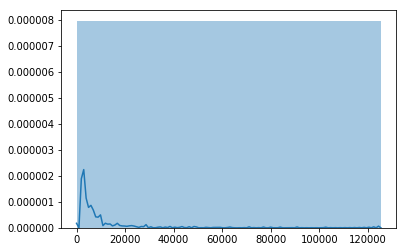

In [134]:
import seaborn as sns
p=sns.distplot(freq_count_data,bins=1)

In [186]:
#freq = pd.Series(' '.join(actual_data["sentence"]).split()).value_counts()[-2000:]
freq2 = pd.Series(' '.join(actual_data["sentence"]).split()).value_counts()[:10]
freq2

patient    125419
call       102331
mg          91054
cma         83713
md          80222
cancel      77222
pt          71008
dr          63638
take        62625
day         58770
dtype: int64

In [187]:
freq2 = list(freq2.index)
actual_data['sentence'] = actual_data['sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in freq2))

In [176]:
freq = list(freq.index)
actual_data['sentence'] = actual_data['sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
actual_data['sentence'].head()

0    better c cough congestion however still c low ...
1    recurrent chest wall pain pneumonia symptom ra...
2    john russo md called today c st cough congesti...
3    need something stronger cough otcs tessalon ca...
4    john russo md called get refill rx moxiflox mg...
Name: sentence, dtype: object

In [194]:
freq2 = pd.Series(' '.join(actual_data["sentence"]).split()).value_counts()[:10]
freq2

oral           56815
need           53737
rn             49311
phone          48788
rx             48410
tablet         46751
called         45966
follow         43952
tab            43105
rescheduled    43023
dtype: int64

In [195]:
actual_data["sentence"]=actual_data["sentence"].astype('str')
actual_data["Categories1"]=actual_data["Categories1"].astype("category")
actual_data["Sub_categories1"]=actual_data["Sub_categories1"].astype("category")
test_data["sentence"]=test_data["sentence"].astype("str")
test_data["Categories1"]=test_data["Categories1"].astype("str")
test_data["Sub_categories1"]=test_data["Sub_categories1"].astype("str")

In [239]:
#actual_data.to_csv("train_data_June.csv",index=False)
#test_data.to_csv("test_data_June.csv",index=False)

In [196]:
#########################################################################################################################

In [197]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(actual_data["sentence"], actual_data["Categories1"], test_size=0.2)

In [198]:
X_test_1=test_data["sentence"]
y_test_1=test_data["Categories1"]

In [199]:
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=200000)
x_train_tfidf = tvec.fit_transform(X_train_1)
x_validation_tfidf = tvec.transform(X_valid_1)
x_test_tfidf=tvec.transform(X_test_1)

In [200]:
clf = LinearSVC(C=1.0,penalty='l2', max_iter=10000,multi_class='ovr',dual=True)
clf.fit(x_train_tfidf,y_train_1)
score1 = clf.score(x_train_tfidf,y_train_1)
score2 = clf.score(x_validation_tfidf, y_valid_1)
score3 = clf.score(x_test_tfidf,y_test_1)
print(clf.score(x_train_tfidf,y_train_1),clf.score(x_validation_tfidf, y_valid_1),clf.score(x_test_tfidf,y_test_1))

0.974554809664 0.78529317183 0.782425172678


In [184]:
clf = linear_model.LogisticRegression(C=10.0,multi_class='ovr',max_iter=3000, penalty='l2')
clf.fit(x_train_tfidf,y_train_1)
score1 = clf.score(x_train_tfidf,y_train_1)
score2 = clf.score(x_validation_tfidf, y_valid_1)
score3 = clf.score(x_test_tfidf,y_test_1)
print(clf.score(x_train_tfidf,y_train_1),clf.score(x_validation_tfidf, y_valid_1),clf.score(x_test_tfidf,y_test_1))

0.963808605003 0.793439811341 0.781273983116


In [185]:
ch2 = SelectKBest(chi2, k=100000)
x_train_chi2_selected = ch2.fit_transform(x_train_tfidf,y_train_1)
x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
x_test_chi2_selected=ch2.transform(x_test_tfidf)
clf2 = LinearSVC(C=1.0,penalty='l2', max_iter=10000,multi_class='ovr',dual=True)
clf2.fit(x_train_chi2_selected, y_train_1)
score1_2 = clf2.score(x_train_chi2_selected,y_train_1)
score2_2 = clf2.score(x_validation_chi2_selected, y_valid_1)
score3_2 = clf2.score(x_test_chi2_selected,y_test_1)
print(score1_2,score2_2,score3_2)

0.947032734387 0.791563940401 0.77705295472


In [146]:
##########################################################################################################################

In [201]:
print(classification_report(y_train_1,clf.predict(x_train_tfidf)))
pd.DataFrame(confusion_matrix(y_train_1,clf.predict(x_train_tfidf)),["APPOINTMENTS","ASK_A_DOCTOR ","LAB","MISCELLANEOUS","PRESCRIPTION"],["APPOINTMENTS","ASK_A_DOCTOR ","LAB","MISCELLANEOUS","PRESCRIPTION"])

               precision    recall  f1-score   support

 APPOINTMENTS       0.98      0.99      0.99     16759
 ASK_A_DOCTOR       0.97      0.97      0.97     27087
          LAB       0.99      0.99      0.99      2977
MISCELLANEOUS       0.99      0.98      0.98      9368
 PRESCRIPTION       0.97      0.96      0.96     18440

  avg / total       0.97      0.97      0.97     74631



,APPOINTMENTS,ASK_A_DOCTOR,LAB,MISCELLANEOUS,PRESCRIPTION
APPOINTMENTS,16631,84,4,23,17
ASK_A_DOCTOR,254,26329,22,58,424
LAB,8,25,2938,1,5
MISCELLANEOUS,38,89,4,9160,77
PRESCRIPTION,5,727,1,33,17674


In [202]:
print(classification_report(y_valid_1,clf.predict(x_validation_tfidf)))
pd.DataFrame(confusion_matrix(y_valid_1,clf.predict(x_validation_tfidf)),["APPOINTMENTS","ASK_A_DOCTOR ","LAB","MISCELLANEOUS","PRESCRIPTION"],["APPOINTMENTS","ASK_A_DOCTOR ","LAB","MISCELLANEOUS","PRESCRIPTION"])

               precision    recall  f1-score   support

 APPOINTMENTS       0.85      0.85      0.85      4104
 ASK_A_DOCTOR       0.74      0.80      0.77      6858
          LAB       0.79      0.75      0.77       708
MISCELLANEOUS       0.76      0.68      0.72      2365
 PRESCRIPTION       0.81      0.77      0.79      4623

  avg / total       0.79      0.79      0.79     18658



,APPOINTMENTS,ASK_A_DOCTOR,LAB,MISCELLANEOUS,PRESCRIPTION
APPOINTMENTS,3496,473,17,93,25
ASK_A_DOCTOR,468,5461,70,229,630
LAB,26,109,533,28,12
MISCELLANEOUS,102,455,41,1611,156
PRESCRIPTION,41,857,11,163,3551


In [203]:
print(classification_report(y_train_1,clf.predict(x_train_tfidf)))

               precision    recall  f1-score   support

 APPOINTMENTS       0.98      0.99      0.99     16759
 ASK_A_DOCTOR       0.97      0.97      0.97     27087
          LAB       0.99      0.99      0.99      2977
MISCELLANEOUS       0.99      0.98      0.98      9368
 PRESCRIPTION       0.97      0.96      0.96     18440

  avg / total       0.97      0.97      0.97     74631



In [204]:
pd.DataFrame(confusion_matrix(y_train_1,clf2.predict(x_train_chi2_selected)),["APPOINTMENTS","ASK_A_DOCTOR ","LAB","MISCELLANEOUS","PRESCRIPTION"],["APPOINTMENTS","ASK_A_DOCTOR ","LAB","MISCELLANEOUS","PRESCRIPTION"])

,APPOINTMENTS,ASK_A_DOCTOR,LAB,MISCELLANEOUS,PRESCRIPTION
APPOINTMENTS,3809,6212,650,2032,4056
ASK_A_DOCTOR,6125,10104,1083,3303,6472
LAB,669,1119,114,387,688
MISCELLANEOUS,2113,3553,338,1115,2249
PRESCRIPTION,4118,6697,750,2400,4475


In [205]:
print(classification_report(y_train_1,clf2.predict(x_train_chi2_selected)))

               precision    recall  f1-score   support

 APPOINTMENTS       0.23      0.23      0.23     16759
 ASK_A_DOCTOR       0.36      0.37      0.37     27087
          LAB       0.04      0.04      0.04      2977
MISCELLANEOUS       0.12      0.12      0.12      9368
 PRESCRIPTION       0.25      0.24      0.25     18440

  avg / total       0.26      0.26      0.26     74631



In [165]:
#######################################################################################################################

In [166]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(actual_data["sentence"], actual_data["Sub_categories1"], test_size=0.2,random_state=42)

In [167]:
X_test_1=test_data["sentence"]
y_test_1=test_data["Sub_categories1"]

In [168]:
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,3), max_features=200000)
x_train_tfidf = tvec.fit_transform(X_train_1)
x_validation_tfidf = tvec.transform(X_valid_1)
x_test_tfidf=tvec.transform(X_test_1)

In [169]:
clf = LinearSVC(C=1.0,penalty='l2', max_iter=10000,multi_class='ovr',dual=True)
#clf = linear_model.LogisticRegression(n_jobs=-1,C=4.0,multi_class='ovr',max_iter=3000, penalty='l2')
clf.fit(x_train_tfidf,y_train_1)
score1 = clf.score(x_train_tfidf,y_train_1)
score2 = clf.score(x_validation_tfidf, y_valid_1)
score3 = clf.score(x_test_tfidf,y_test_1)
print(clf.score(x_train_tfidf,y_train_1),clf.score(x_validation_tfidf, y_valid_1),clf.score(x_test_tfidf,y_test_1))

0.972678913588 0.718565762676 0.661166538757


In [174]:
print(clf.score(x_train_tfidf,y_train_1),clf.score(x_validation_tfidf, y_valid_1),clf.score(x_test_tfidf,y_test_1))
print(classification_report(y_train_1,clf.predict(x_train_tfidf)))
pd.DataFrame(confusion_matrix(y_train_1,clf.predict(x_train_tfidf)),["CANCELLATION","CHANGE OF HOSPITAL","CHANGE OF PHARMACY ",
                                                                     "CHANGE OF PROVIDER","FOLLOW UP ON PREVIOUS REQUEST","LAB RESULTS",
                                                                     "MEDICATION RELATED","NEW APPOINTMENT","OTHERS","PRIOR AUTHORIZATION",
                                                                     "PROVIDER","QUERIES FROM INSURANCE FIRM","QUERIES FROM PHARMACY",
                                                                     "QUERY ON CURRENT APPOINTMENT","REFILL","RESCHEDULING",
                                                                     "RUNNING LATE TO APPOINTMENT","SHARING OF HEALTH RECORDS",
                                                                     "SHARING OF LAB RECORDS","SYMPTOMS"],["CANCELLATION","CHANGE OF HOSPITAL","CHANGE OF PHARMACY ",
                                                                     "CHANGE OF PROVIDER","FOLLOW UP ON PREVIOUS REQUEST","LAB RESULTS",
                                                                     "MEDICATION RELATED","NEW APPOINTMENT","OTHERS","PRIOR AUTHORIZATION",
                                                                     "PROVIDER","QUERIES FROM INSURANCE FIRM","QUERIES FROM PHARMACY",
                                                                     "QUERY ON CURRENT APPOINTMENT","REFILL","RESCHEDULING",
                                                                     "RUNNING LATE TO APPOINTMENT","SHARING OF HEALTH RECORDS",
                                                                     "SHARING OF LAB RECORDS","SYMPTOMS"])

0.972678913588 0.718565762676 0.661166538757
                                               precision    recall  f1-score   support

                                 CANCELLATION       0.99      0.99      0.99       508
                           CHANGE OF HOSPITAL       1.00      0.93      0.97       166
                           CHANGE OF PHARMACY       1.00      0.82      0.90        45
                           CHANGE OF PROVIDER       0.98      1.00      0.99      2589
                FOLLOW UP ON PREVIOUS REQUEST       1.00      0.93      0.96        58
                                  LAB RESULTS       0.99      0.99      0.99      2103
                           MEDICATION RELATED       0.96      0.98      0.97     23186
                              NEW APPOINTMENT       0.98      1.00      0.99     14918
                                       OTHERS       0.99      0.97      0.98      4508
                          PRIOR AUTHORIZATION       0.98      0.99      0.99       5

,CANCELLATION,CHANGE OF HOSPITAL,CHANGE OF PHARMACY,CHANGE OF PROVIDER,FOLLOW UP ON PREVIOUS REQUEST,LAB RESULTS,MEDICATION RELATED,NEW APPOINTMENT,OTHERS,PRIOR AUTHORIZATION,PROVIDER,QUERIES FROM INSURANCE FIRM,QUERIES FROM PHARMACY,QUERY ON CURRENT APPOINTMENT,REFILL,RESCHEDULING,RUNNING LATE TO APPOINTMENT,SHARING OF HEALTH RECORDS,SHARING OF LAB RECORDS,SYMPTOMS
CANCELLATION,503,0,0,0,0,0,2,2,0,0,0,0,0,0,0,1,0,0,0,0
CHANGE OF HOSPITAL,0,155,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CHANGE OF PHARMACY,0,0,37,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0
CHANGE OF PROVIDER,0,0,0,2581,0,1,3,2,2,0,0,0,0,0,0,0,0,0,0,0
FOLLOW UP ON PREVIOUS REQUEST,0,0,0,1,54,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0
LAB RESULTS,0,0,0,1,0,2075,22,1,0,0,0,0,0,0,1,0,0,0,3,0
MEDICATION RELATED,2,0,0,6,0,14,22636,142,10,1,3,0,4,0,332,0,0,4,2,30
NEW APPOINTMENT,0,0,0,6,0,0,36,14856,7,0,2,0,0,0,8,0,0,0,0,3
OTHERS,1,0,0,10,0,2,47,27,4383,4,8,0,0,0,18,0,0,8,0,0
PRIOR AUTHORIZATION,0,0,0,0,0,0,2,0,0,547,0,0,0,0,2,0,0,1,0,0


In [ ]:
######################################################################################################

In [208]:
from gensim.models import Word2Vec

C:\Users\1520\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [206]:
#to create a list of words in a list
list_of_words= []
for i in range (0,len(actual_data["sentence"])):
    list_of_words.append(nltk.word_tokenize(actual_data["sentence"][i]))

In [209]:
wordtovec = Word2Vec(list_of_words,min_count =2)

In [210]:
wc_words = list(wordtovec.wv.vocab)
print(wc_words)

['better', 'c', 'cough', 'congestion', 'however', 'still', 'low', 'grade', 'fever', 'sleeping', 'often', 'say', 'worried', 'flu', 'pcn', 'allergy', 'pharmacy', 'pick', 'drug', 'unclear', 'need', 'mo', 'abx', 'bactrim', 'one', 'd', 'po', 'bid', 'gave', 'paramete', 'rescheduled', 'start', 'listed', 'sulfamethoxazole', 'trimethoprim', 'oral', 'tab', 'penicillin', 'v', 'potassium', 'moderate', 'recurrent', 'chest', 'wall', 'pain', 'pneumonia', 'symptom', 'ravisankar', 'r', 'avva', 'discussed', 'alva', 'treat', 'levaquin', 'week', 'probiotic', 'recommended', 'complete', 'resolution', 'additional', 'therapy', 'consultation', 'pulmonology', 'ct', 'scan', 'reviewed', 'john', 'russo', 'called', 'today', 'st', 'head', 'seve', 'nasal', 'issue', 'seems', 'like', 'sinusitis', 'mucinex', 'ok', 'plain', 'old', 'guafen', 'dm', 'benzonatate', 'cap', 'tid', 'prn', 'cefdinir', 'something', 'stronger', 'otcs', 'tessalon', 'get', 'refill', 'rx', 'x', 'bronchitis', 'sputum', 'cv', 'battleground', 'sound', '

In [238]:
wc_words

['better',
 'c',
 'cough',
 'congestion',
 'however',
 'still',
 'low',
 'grade',
 'fever',
 'sleeping',
 'often',
 'say',
 'worried',
 'flu',
 'pcn',
 'allergy',
 'pharmacy',
 'pick',
 'drug',
 'unclear',
 'need',
 'mo',
 'abx',
 'bactrim',
 'one',
 'd',
 'po',
 'bid',
 'gave',
 'paramete',
 'rescheduled',
 'start',
 'listed',
 'sulfamethoxazole',
 'trimethoprim',
 'oral',
 'tab',
 'penicillin',
 'v',
 'potassium',
 'moderate',
 'recurrent',
 'chest',
 'wall',
 'pain',
 'pneumonia',
 'symptom',
 'ravisankar',
 'r',
 'avva',
 'discussed',
 'alva',
 'treat',
 'levaquin',
 'week',
 'probiotic',
 'recommended',
 'complete',
 'resolution',
 'additional',
 'therapy',
 'consultation',
 'pulmonology',
 'ct',
 'scan',
 'reviewed',
 'john',
 'russo',
 'called',
 'today',
 'st',
 'head',
 'seve',
 'nasal',
 'issue',
 'seems',
 'like',
 'sinusitis',
 'mucinex',
 'ok',
 'plain',
 'old',
 'guafen',
 'dm',
 'benzonatate',
 'cap',
 'tid',
 'prn',
 'cefdinir',
 'something',
 'stronger',
 'otcs',
 'tes

In [228]:
wordtovec.most_similar('refill')," ", wordtovec.most_similar('treat')," ",wordtovec.most_similar('sch'),"  ",wordtovec.most_similar('others')," ",wordtovec.most_similar('pharmacy')

([('refilled', 0.7376210689544678),
  ('generic', 0.5920748114585876),
  ('rx', 0.5647557973861694),
  ('supply', 0.5623124241828918),
  ('rxs', 0.557449460029602),
  ('fill', 0.5152488946914673),
  ('filled', 0.514531672000885),
  ('adderal', 0.503299355506897),
  ('optum', 0.500109076499939),
  ('refil', 0.496293306350708)],
 ' ',
 [('empirically', 0.7130782008171082),
  ('empiric', 0.6720041036605835),
  ('treated', 0.6596523523330688),
  ('treating', 0.6421520709991455),
  ('develop', 0.6241792440414429),
  ('viral', 0.6114014387130737),
  ('treatment', 0.6033647060394287),
  ('course', 0.6031515002250671),
  ('recurrent', 0.6001474857330322),
  ('appropriate', 0.5896098613739014)],
 ' ',
 [('canx', 0.6921508312225342),
  ('cancelled', 0.6517816781997681),
  ('sched', 0.6513307094573975),
  ('rescheduling', 0.6307454705238342),
  ('cxd', 0.6024050712585449),
  ('canceled', 0.5593900084495544),
  ('reqested', 0.5535797476768494),
  ('cancelling', 0.5510756969451904),
  ('toby', 0.55

In [229]:
wordtovec.most_similar('appointment')," ",wordtovec.most_similar('rx')

([('appt', 0.8196805715560913),
  ('appts', 0.7483638525009155),
  ('opening', 0.6818182468414307),
  ('ov', 0.6592180728912354),
  ('app', 0.6413149237632751),
  ('appoitnment', 0.6400079727172852),
  ('seen', 0.6116269826889038),
  ('apt', 0.5848623514175415),
  ('availability', 0.5815694332122803),
  ('appointemnt', 0.560260534286499)],
 ' ',
 [('rxs', 0.663760781288147),
  ('refill', 0.5647557973861694),
  ('dosage', 0.5498647689819336),
  ('script', 0.5177720189094543),
  ('pharmacist', 0.5025569200515747),
  ('refilled', 0.5012604594230652),
  ('quanity', 0.4903452396392822),
  ('supply', 0.4716990888118744),
  ('kobiglyze', 0.4630366861820221),
  ('costco', 0.46212223172187805)])

In [230]:
wordtovec.most_similar('sch'),"  ",wordtovec.most_similar('others')," ",wordtovec.most_similar('pharmacy')

([('canx', 0.6921508312225342),
  ('cancelled', 0.6517816781997681),
  ('sched', 0.6513307094573975),
  ('rescheduling', 0.6307454705238342),
  ('cxd', 0.6024050712585449),
  ('canceled', 0.5593900084495544),
  ('reqested', 0.5535797476768494),
  ('cancelling', 0.5510756969451904),
  ('toby', 0.5505771040916443),
  ('cx', 0.5493984222412109)],
 '  ',
 [('tolerated', 0.6438447833061218),
  ('although', 0.6010518074035645),
  ('pushing', 0.599689781665802),
  ('qol', 0.5983715057373047),
  ('adequate', 0.5908466577529907),
  ('agent', 0.5800844430923462),
  ('become', 0.5789459943771362),
  ('avoiding', 0.5742166638374329),
  ('retain', 0.5700535178184509),
  ('experience', 0.5690360069274902)],
 ' ',
 [('pharm', 0.70658278465271),
  ('pharamcy', 0.6123807430267334),
  ('optum', 0.6079827547073364),
  ('pharmacist', 0.5995091199874878),
  ('costco', 0.5621041059494019),
  ('prescription', 0.5126954317092896),
  ('primemail', 0.5124879479408264),
  ('pharamacy', 0.5064895749092102),
  ('m

In [235]:
wordtovec